## 0. Import Data

In [15]:
import kagglehub
import pandas as pd
import sqlite3
from pathlib import Path
from pydantic import BaseModel, field_validator
import numpy as np
import seaborn as sns
import datetime

## 1. Loading Data

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("new-york-city/nyc-east-river-bicycle-crossings")
print("Path to dataset files:", path)
dataset_dir = Path(path)
csv_files = list(dataset_dir.glob("*.csv"))
if not csv_files:
    raise FileNotFoundError("No CSV File found in the Kaggle Dataset")
csv_path = csv_files[0]
print(f"Using Dataset: {csv_path.name}")

Path to dataset files: /Users/john/.cache/kagglehub/datasets/new-york-city/nyc-east-river-bicycle-crossings/versions/1
Using Dataset: nyc-east-river-bicycle-counts.csv


In [11]:
df_raw = pd.read_csv(csv_path, index_col=0 )

In [13]:
df_raw.head()

,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,2016-04-01 00:00:00,2016-04-01 00:00:00,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0,11497
1,2016-04-02 00:00:00,2016-04-02 00:00:00,55.0,48.9,0.15,827.0,1646,2565.0,1884.0,6922
2,2016-04-03 00:00:00,2016-04-03 00:00:00,39.9,34.0,0.09,526.0,1232,1695.0,1306.0,4759
3,2016-04-04 00:00:00,2016-04-04 00:00:00,44.1,33.1,0.47 (S),521.0,1067,1440.0,1307.0,4335
4,2016-04-05 00:00:00,2016-04-05 00:00:00,42.1,26.1,0,1416.0,2617,3081.0,2357.0,9471


In [30]:
df_raw.Precipitation.dtype

dtype('O')

In [14]:
df_raw.Date.dtype

dtype('O')

## 2. Preprocess Data

In [52]:
df_raw = df_raw.rename(columns= {"High Temp (°F)": "HighTemp",
                                  "Low Temp (°F)" : "LowTemp",
                                    "Total": "Count"})

In [53]:
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw['Day'] = pd.to_datetime(df_raw['Day'])
df_raw['Precipitation'].unique()

array([0.01, 0.15, 0.09, 0.47, 0.  , 0.2 , 0.16, 0.24, 0.05])

In [54]:
def clean_precip_and_extract_tags(val):
    if pd.isna(val):
        return 0.0, 0, 0

    val = str(val).strip()

    # Set trace amounts and blanks to 0
    if val == 'T' or val == '':
        return 0.0, 0, 0

    is_snow = int('(S)' in val) # if snow is in precipitation
    is_rain = int('(R)' in val) # if rain is in precipitation

    # Get numeric part (before any space or parenthesis)
    numeric_part = val.split()[0]
    
    try:
        precip_val = float(numeric_part)
    except ValueError:
        precip_val = 0.0  # fallback for weird formats

    return precip_val, is_snow, is_rain

# Apply function to your column
df_raw[['Precipitation', 'is_snow', 'is_rain']] = df_raw['Precipitation'].apply(
    clean_precip_and_extract_tags
).apply(pd.Series)


In [56]:
df_raw['day_of_week'] = df_raw['Date'].dt.day_name()
df_raw['month'] = df_raw['Date'].dt.month
# binary precip
df_raw['precip_bin'] = (df_raw['Precipitation'] > 0).astype(int)
# maybe temp average
df_raw['temp_avg'] = (df_raw['HighTemp'] + df_raw['LowTemp']) / 2

In [57]:
df_raw

,Date,Day,HighTemp,LowTemp,Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Count,day_of_week,month,is_snow,is_rain,precip_bin,temp_avg
0,2016-04-01,2016-04-01,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0,11497,Friday,4,0.0,0.0,1,72.05
1,2016-04-02,2016-04-02,55.0,48.9,0.15,827.0,1646,2565.0,1884.0,6922,Saturday,4,0.0,0.0,1,51.95
2,2016-04-03,2016-04-03,39.9,34.0,0.09,526.0,1232,1695.0,1306.0,4759,Sunday,4,0.0,0.0,1,36.95
3,2016-04-04,2016-04-04,44.1,33.1,0.47,521.0,1067,1440.0,1307.0,4335,Monday,4,0.0,0.0,1,38.60
4,2016-04-05,2016-04-05,42.1,26.1,0.00,1416.0,2617,3081.0,2357.0,9471,Tuesday,4,0.0,0.0,0,34.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2016-04-26,2016-04-26,60.1,46.9,0.24,1997.0,3520,4559.0,2929.0,13005,Tuesday,4,0.0,0.0,1,53.50
206,2016-04-27,2016-04-27,62.1,46.9,0.00,3343.0,5606,6577.0,4388.0,19914,Wednesday,4,0.0,0.0,0,54.50
207,2016-04-28,2016-04-28,57.9,48.0,0.00,2486.0,4152,5336.0,3657.0,15631,Thursday,4,0.0,0.0,0,52.95
208,2016-04-29,2016-04-29,57.0,46.9,0.05,2375.0,4178,5053.0,3348.0,14954,Friday,4,0.0,0.0,1,51.95



## 3. EDA

In [58]:
# df_long = pd.melt(
#     df_raw,
#     id_vars=['Date', 'HighTemp', 'LowTemp', 'temp_avg', 'Precipitation', 'precip_bin', 'day_of_week', 'month'],  # keep these as-is
#     value_vars=['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge'],  # "melt" these
#     var_name='Bridge',     # name of new column that holds the original column names
#     value_name='Count'     # name of new column that holds the values
# )


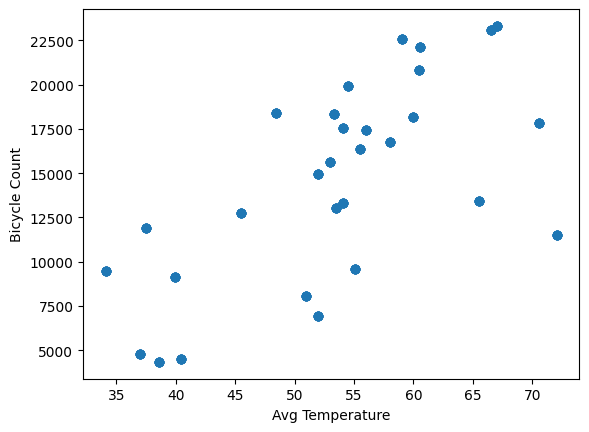

In [62]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.scatter(df_raw['temp_avg'], df_raw['Count'])
plt.xlabel("Avg Temperature")
plt.ylabel("Bicycle Count")
plt.show()

In [63]:
formula = "Count ~ temp_avg + precip_bin + C(day_of_week) + C(month)"
poisson_mod = smf.glm(formula=formula, data=df_raw, family=sm.families.Poisson()).fit()
print(poisson_mod.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                  210
Model:                            GLM   Df Residuals:                      201
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49561.
Date:                Fri, 17 Oct 2025   Deviance:                       96744.
Time:                        17:34:03   Pearson chi2:                 9.72e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

## Summary:

- Bike counts vary by day of week, with some days higher and some lower than Fridays.

- Warmer days increase counts moderately.

- Rain/snow strongly reduces counts.

- The model fits well, but check for overdispersion next.

## 5. check overdispersion

In [78]:
deviance = poisson_mod.deviance
df_resid = poisson_mod.df_resid
print("Deviance / df:", deviance / df_resid)

Deviance / df: 481.3123245184402


## 6. negative binomial

In [79]:
nb_mod = smf.glm(formula=formula, data=df_raw, family=sm.families.NegativeBinomial()).fit()
print(nb_mod.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                  210
Model:                            GLM   Df Residuals:                      201
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2206.9
Date:                Fri, 17 Oct 2025   Deviance:                       8.5725
Time:                        17:54:54   Pearson chi2:                     8.13
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1401
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


## 7. validation / forecasting

In [74]:
train = df_raw[df_raw['Date'] < '2017-08-01']
test = df_raw[df_raw['Date'] <= '2017-08-01']
mod_cv = smf.glm(formula=formula, data=train, family=sm.families.Poisson()).fit()
pred = mod_cv.predict(test)
# compare pred to test['Count'], compute MAE, RMSE, plot.

## # Save model

In [82]:
import joblib
joblib.dump(nb_mod, "bike_model_nb.pkl")

['bike_model_nb.pkl']